In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Quick data visualization

First let's see how our images look like:

📂 Classes détectées : ['Lung_Opacity', 'Normal', 'COVID', 'Viral Pneumonia', 'train', 'test']
⚠ Pas de dossier 'images' trouvé pour train
⚠ Pas de dossier 'images' trouvé pour test


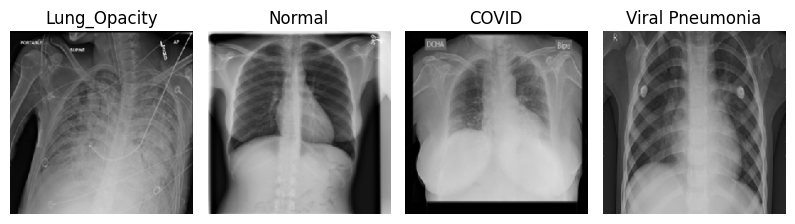

In [ ]:
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img

# Chemin du dataset
base_path = "/content/drive/My Drive/COVID-19_Radiography_Dataset"

# Vérifier les classes (sous-dossiers)
classes = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

# Vérifier si on a bien trouvé des classes
if not classes:
    print("❌ Aucun sous-dossier trouvé, vérifiez le dataset.")
else:
    print(f"📂 Classes détectées : {classes}")

    plt.figure(figsize=(12, 6))
    images_found = 0

    # Afficher une image par classe
    for i, class_name in enumerate(classes):
        images_path = os.path.join(base_path, class_name, "images")  # Prendre uniquement les images
        if not os.path.exists(images_path):
            print(f"⚠ Pas de dossier 'images' trouvé pour {class_name}")
            continue  # Passer à la classe suivante

        # Lister les fichiers images
        image_files = [f for f in os.listdir(images_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

        if image_files:
            img_path = os.path.join(images_path, image_files[0])
            img = load_img(img_path, target_size=(224, 224))

            plt.subplot(1, len(classes), images_found + 1)
            plt.imshow(img)
            plt.title(class_name)
            plt.axis("off")

            images_found += 1

    if images_found > 0:
        plt.tight_layout()
        plt.show()
    else:
        print("❌ Aucune image trouvée dans les classes.")


In [ ]:

for expression in os.listdir(base_path + "/train"):
    print(str(len(os.listdir(base_path+ "/train/" + expression))) + " " + expression + " images")

6014 Lung_Opacity images
9782 Normal images
3480 COVID images
1293 Viral Pneumonia images


In [ ]:

import os
import pandas as pd
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📂 Chemin du dossier d'entraînement
train_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"

classes = os.listdir(train_dir)
data = []

for class_name in classes:
    class_path = os.path.join(train_dir, class_name)
    images = [
        os.path.join(class_name, img)
        for img in os.listdir(class_path)
        if img.endswith(('png', 'jpg', 'jpeg'))
    ]
    data.extend([(img, class_name) for img in images])


df = pd.DataFrame(data, columns=["filename", "class"])


min_samples = df['class'].value_counts().min()
df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


pic_size = 224
batch_size = 32


datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_dataframe(
    df_balanced,
    directory=train_dir,
    x_col='filename',
    y_col='class',
    target_size=(pic_size, pic_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)


print("📊 Nouvelle distribution des classes :\n", df_balanced['class'].value_counts())


<ipython-input-6-af226ed1a94c>:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df.groupby('class', group_keys=False).apply(lambda x: x.sample(min_samples, random_state=42))


Found 5172 validated image filenames belonging to 4 classes.
📊 Nouvelle distribution des classes :
 class
COVID              1293
Lung_Opacity       1293
Normal             1293
Viral Pneumonia    1293
Name: count, dtype: int64


The image expressions in our training dataset are pretty balanced, except for the 'disgust' category.

Deep learning models are trained by being fed with batches of data. Keras has a very useful class to automatically feed data from a directory: ImageDataGenerator.

It can also perform data augmentation while getting the images (randomly rotating the image, zooming, etc.). This method is often used as a way to artificially get more data when the dataset has a small size.

The function flow_from_directory() specifies how the generator should import the images (path, image size, colors, etc.).


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, VGG16 # Import VGG16 here
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D


train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


local_weights_path = "imagenet"
IMG_SHAPE = (224, 224, 3)



def create_model():
    baseModel = VGG16(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights=local_weights_path
    )
    print("Number of layers in the base model: ", len(baseModel.layers))

    # Removed redundant imports from here

    from tensorflow.keras.regularizers import l2

    for layer in baseModel.layers[:15]:
      layer.trainable = False
    for layer in baseModel.layers[15:]:
      layer.trainable = True


    model = Sequential([
        baseModel,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.6),
        Dense(64, activation='relu'),
        Dropout(0.6),
        Dense(4, activation='softmax')
    ])


    return model
    model=create_model()
    model.summary()

In [ ]:
model=create_model()
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Number of layers in the base model:  19


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,788,868 (56.42 MB)

 Trainable params: 7,153,604 (27.29 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-3,
        patience=5, verbose=1, mode='auto',
        restore_best_weights=True)

In [ ]:
def balance_dataframe(df, label_col='class'):
    # Trouver la taille minimale des classes
    min_size = df[label_col].value_counts().min()
    # Pour chaque classe, échantillonner `min_size` lignes
    balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
    return balanced_df

Fold 1/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4084 validated image filenames belonging to 4 classes.
Found 948 validated image filenames belonging to 4 classes.
Found 4137 validated image filenames belonging to 4 classes.
Found 1035 validated image filenames belonging to 4 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Number of layers in the base model:  19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 1848s 28s/step - accuracy: 0.3101 - loss: 1.4988 - val_accuracy: 0.6338 - val_loss: 0.9563
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 540ms/step - accuracy: 0.5183 - loss: 1.0743 - val_accuracy: 0.7623 - val_loss: 0.7244
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 578ms/step - accuracy: 0.6536 - loss: 0.8643 - val_accuracy: 0.8570 - val_loss: 0.4934
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 527ms/step - accuracy: 0.7212 - loss: 0.7154 - val_accuracy: 0.8570 - val_loss: 0.4546
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 554ms/step - accuracy: 0.7751 - loss: 0.6126 - val_accuracy: 0.8947 - val_loss: 0.3416
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 561ms/step - accuracy: 0.8050 - loss: 0.5430 - val_accuracy: 0.9082 - val_loss: 0.2826
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 582ms/step - accuracy: 0.8407 - loss: 0.4847 - val_accuracy: 0.9043 - val_loss: 0.2737
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 535ms/step - accuracy: 0.8659 - loss: 0.4038 - val_accu

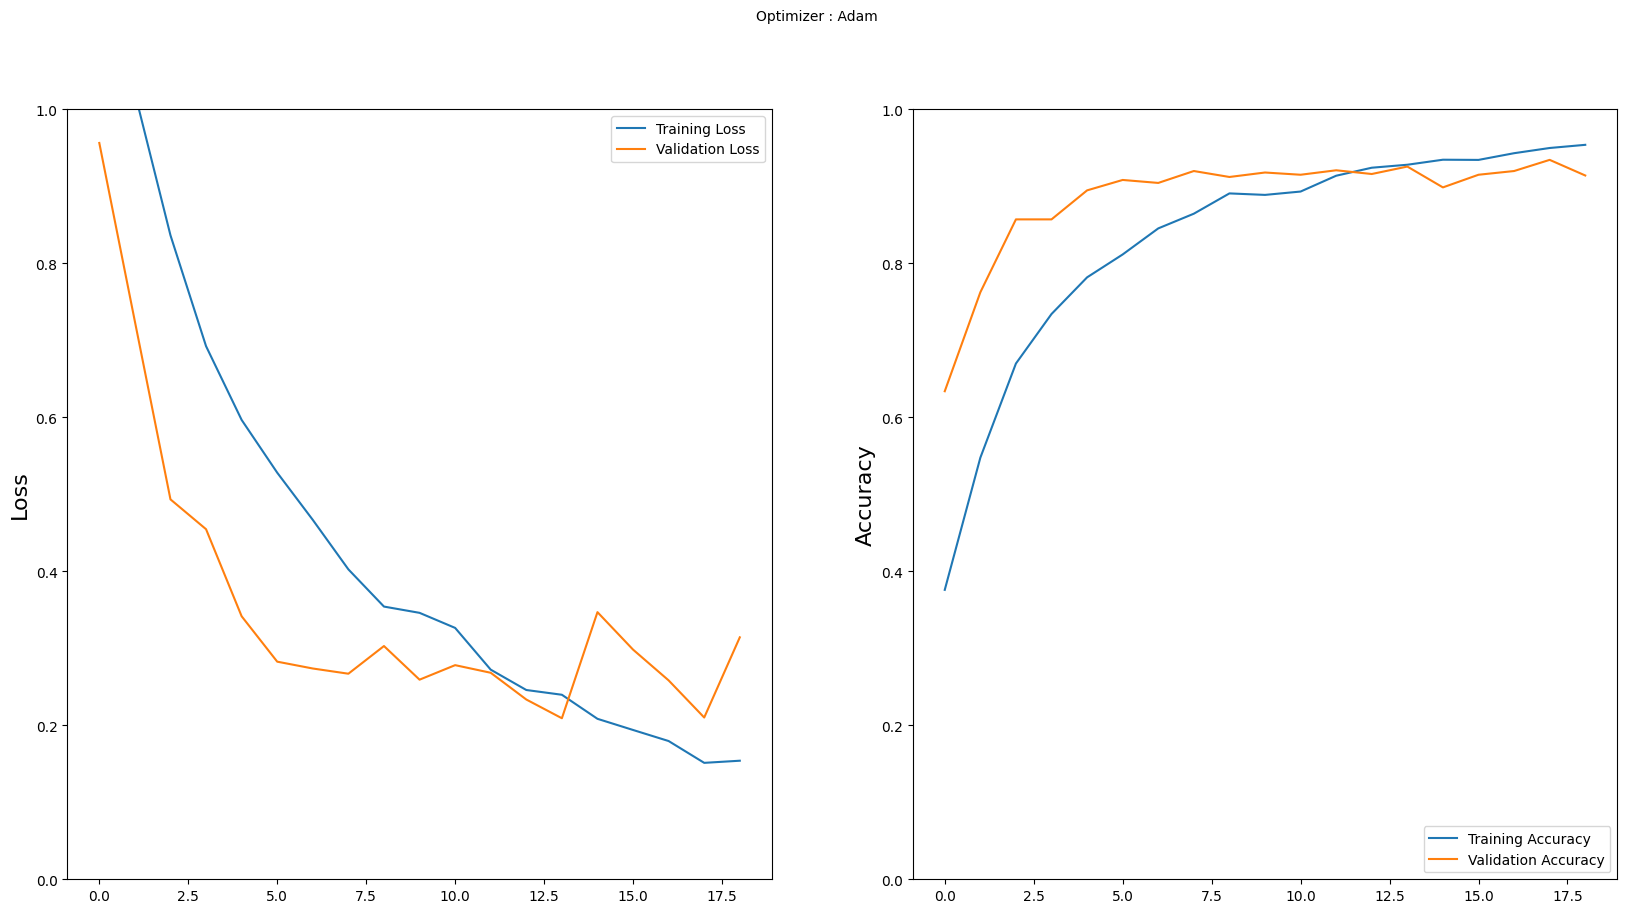

Fold 2/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4064 validated image filenames belonging to 4 classes.
Found 968 validated image filenames belonging to 4 classes.
Found 4137 validated image filenames belonging to 4 classes.
Found 1035 validated image filenames belonging to 4 classes.
Number of layers in the base model:  19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 46s 621ms/step - accuracy: 0.3100 - loss: 1.4716 - val_accuracy: 0.6744 - val_loss: 0.9284
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 74s 555ms/step - accuracy: 0.5369 - loss: 1.0619 - val_accuracy: 0.8029 - val_loss: 0.6575
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 612ms/step - accuracy: 0.6766 - loss: 0.8361 - val_accuracy: 0.8841 - val_loss: 0.4239
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 580ms/step - accuracy: 0.7539 - loss: 0.6603 - val_accuracy: 0.9092 - val_loss: 0.3217
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 526ms/step - accuracy: 0.7920 - loss: 0.5789 - val_accuracy: 0.9101 - val_loss: 0.2939
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 522ms/step - accuracy: 0.8369 - loss: 0.4653 - val_accuracy: 0.8947 - val_loss: 0.2994
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 513ms/step - accuracy: 0.8627 - loss: 0.4182 - val_accuracy: 0.9034 - val_loss: 0.2816
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 42s 528ms/step - accuracy: 0.8584 - loss: 0.3964 - val_accu

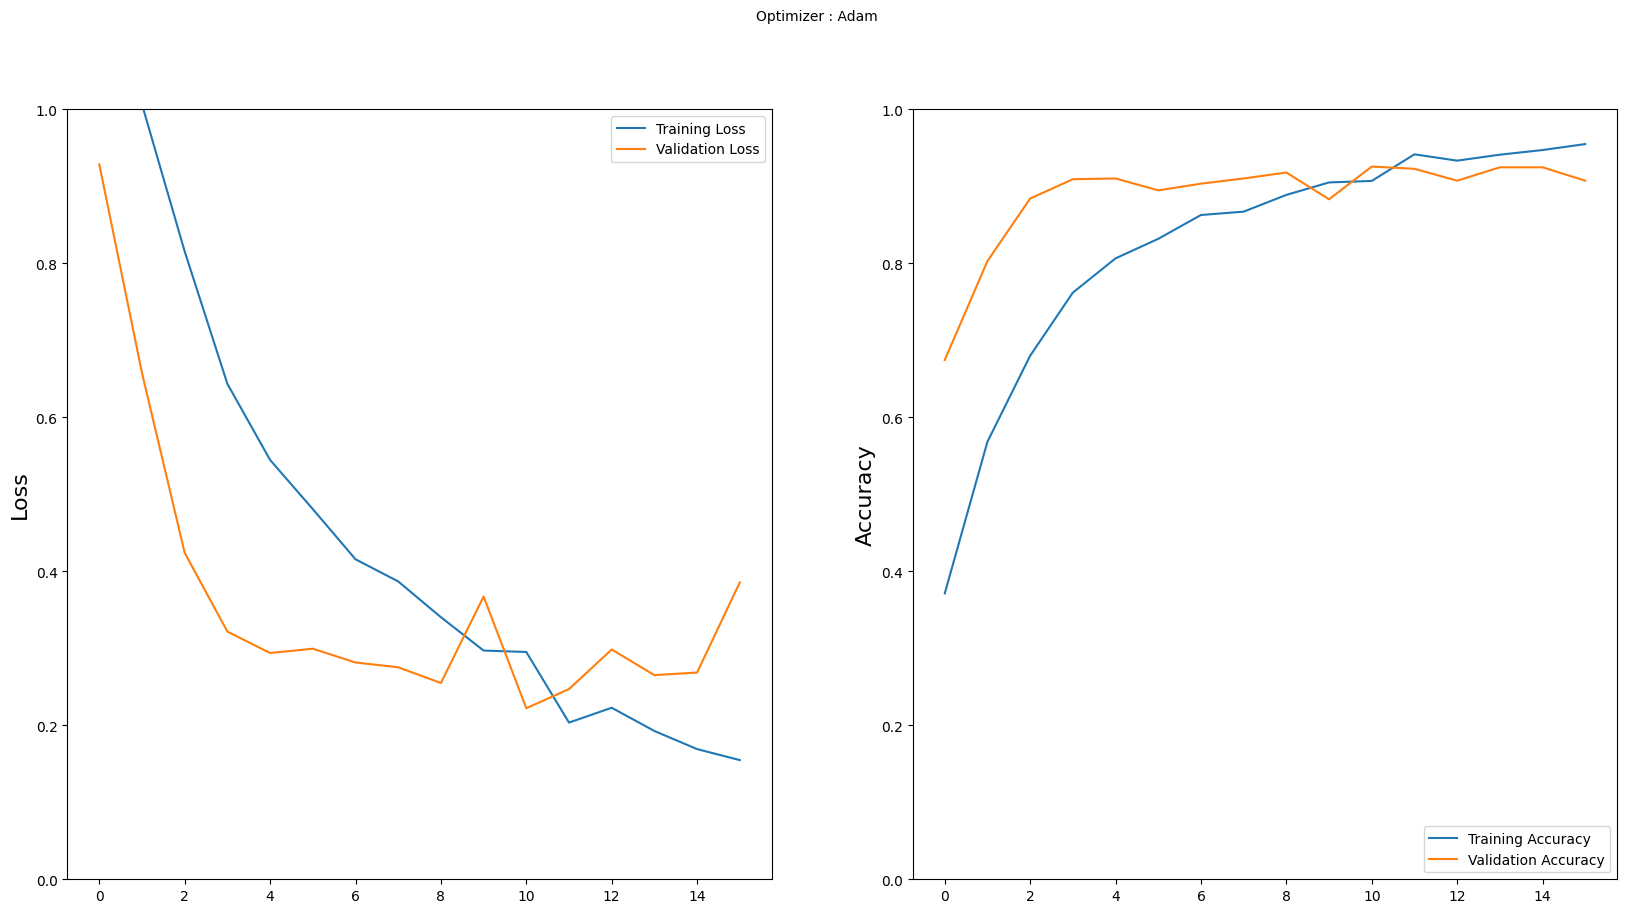

Fold 3/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4096 validated image filenames belonging to 4 classes.
Found 956 validated image filenames belonging to 4 classes.
Found 4138 validated image filenames belonging to 4 classes.
Found 1034 validated image filenames belonging to 4 classes.
Number of layers in the base model:  19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 64s 931ms/step - accuracy: 0.3283 - loss: 1.4231 - val_accuracy: 0.6905 - val_loss: 0.9063
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 517ms/step - accuracy: 0.5894 - loss: 0.9878 - val_accuracy: 0.8104 - val_loss: 0.5815
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 532ms/step - accuracy: 0.6955 - loss: 0.7610 - val_accuracy: 0.8288 - val_loss: 0.4560
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 37s 573ms/step - accuracy: 0.7724 - loss: 0.6230 - val_accuracy: 0.8897 - val_loss: 0.3265
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 520ms/step - accuracy: 0.8202 - loss: 0.4986 - val_accuracy: 0.8936 - val_loss: 0.3269
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 539ms/step - accuracy: 0.8623 - loss: 0.4297 - val_accuracy: 0.8965 - val_loss: 0.3136
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 583ms/step - accuracy: 0.8700 - loss: 0.4094 - val_accuracy: 0.9197 - val_loss: 0.2464
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 576ms/step - accuracy: 0.8764 - loss: 0.3775 - val_accu

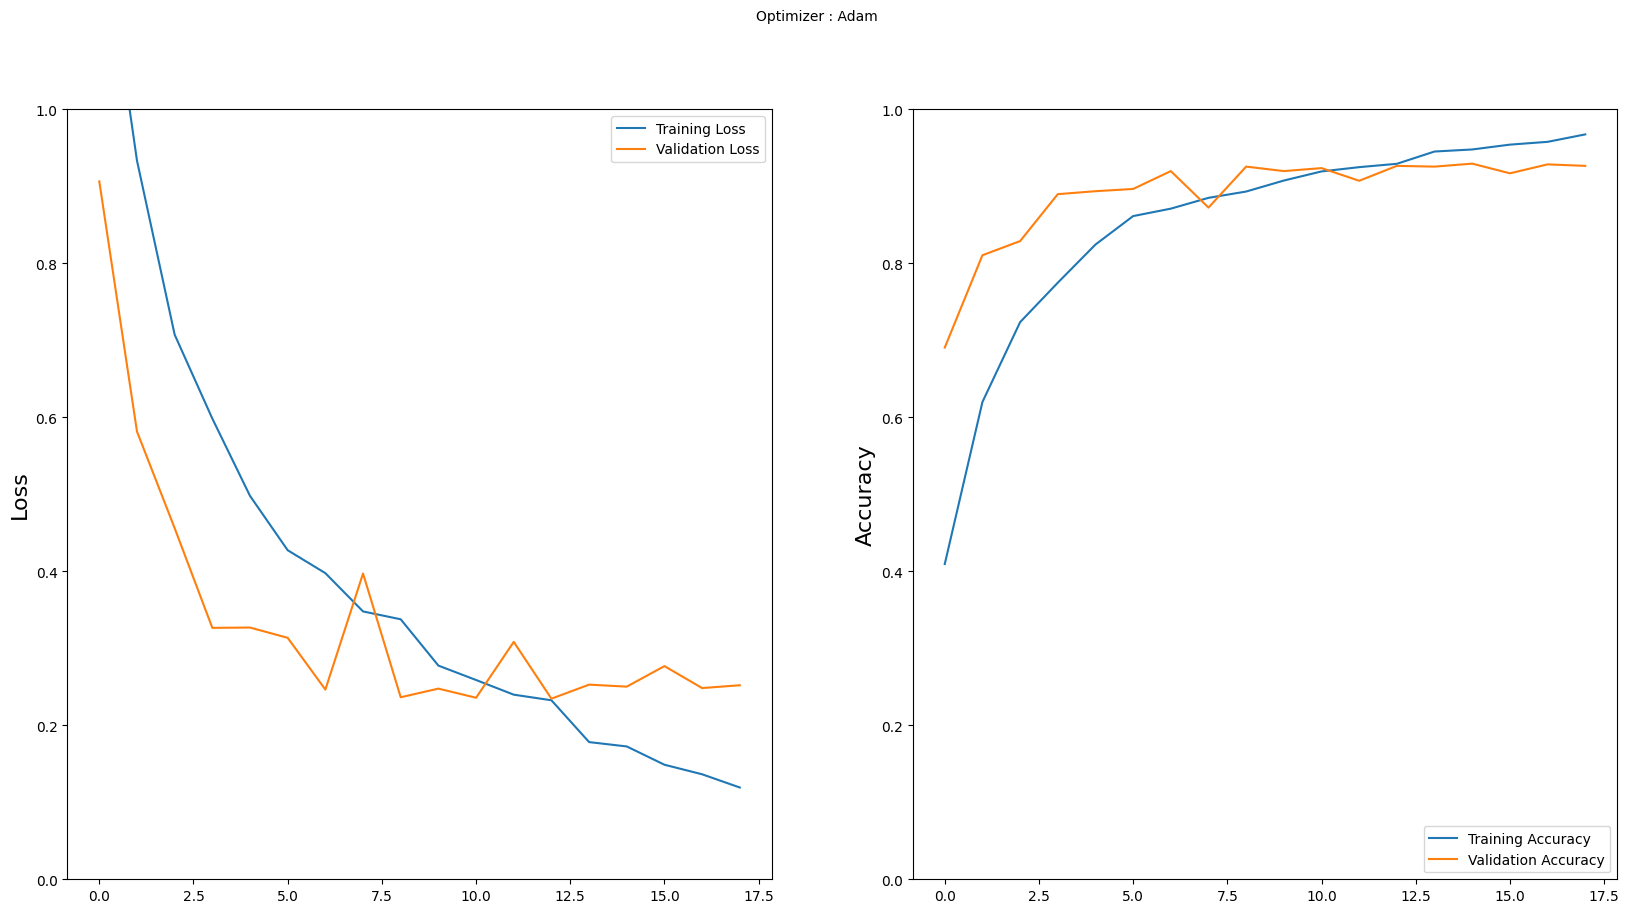

Fold 4/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4104 validated image filenames belonging to 4 classes.
Found 984 validated image filenames belonging to 4 classes.
Found 4138 validated image filenames belonging to 4 classes.
Found 1034 validated image filenames belonging to 4 classes.
Number of layers in the base model:  19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 43s 586ms/step - accuracy: 0.3082 - loss: 1.4821 - val_accuracy: 0.6634 - val_loss: 1.0446
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 519ms/step - accuracy: 0.5138 - loss: 1.1058 - val_accuracy: 0.8095 - val_loss: 0.6978
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 528ms/step - accuracy: 0.6528 - loss: 0.8823 - val_accuracy: 0.8308 - val_loss: 0.5492
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 532ms/step - accuracy: 0.7363 - loss: 0.7175 - val_accuracy: 0.8607 - val_loss: 0.4223
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 530ms/step - accuracy: 0.7816 - loss: 0.6263 - val_accuracy: 0.8878 - val_loss: 0.3241
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 38s 586ms/step - accuracy: 0.8160 - loss: 0.5242 - val_accuracy: 0.8859 - val_loss: 0.3136
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 34s 524ms/step - accuracy: 0.8518 - loss: 0.4502 - val_accuracy: 0.8897 - val_loss: 0.2958
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 45s 589ms/step - accuracy: 0.8789 - loss: 0.3725 - val_accu

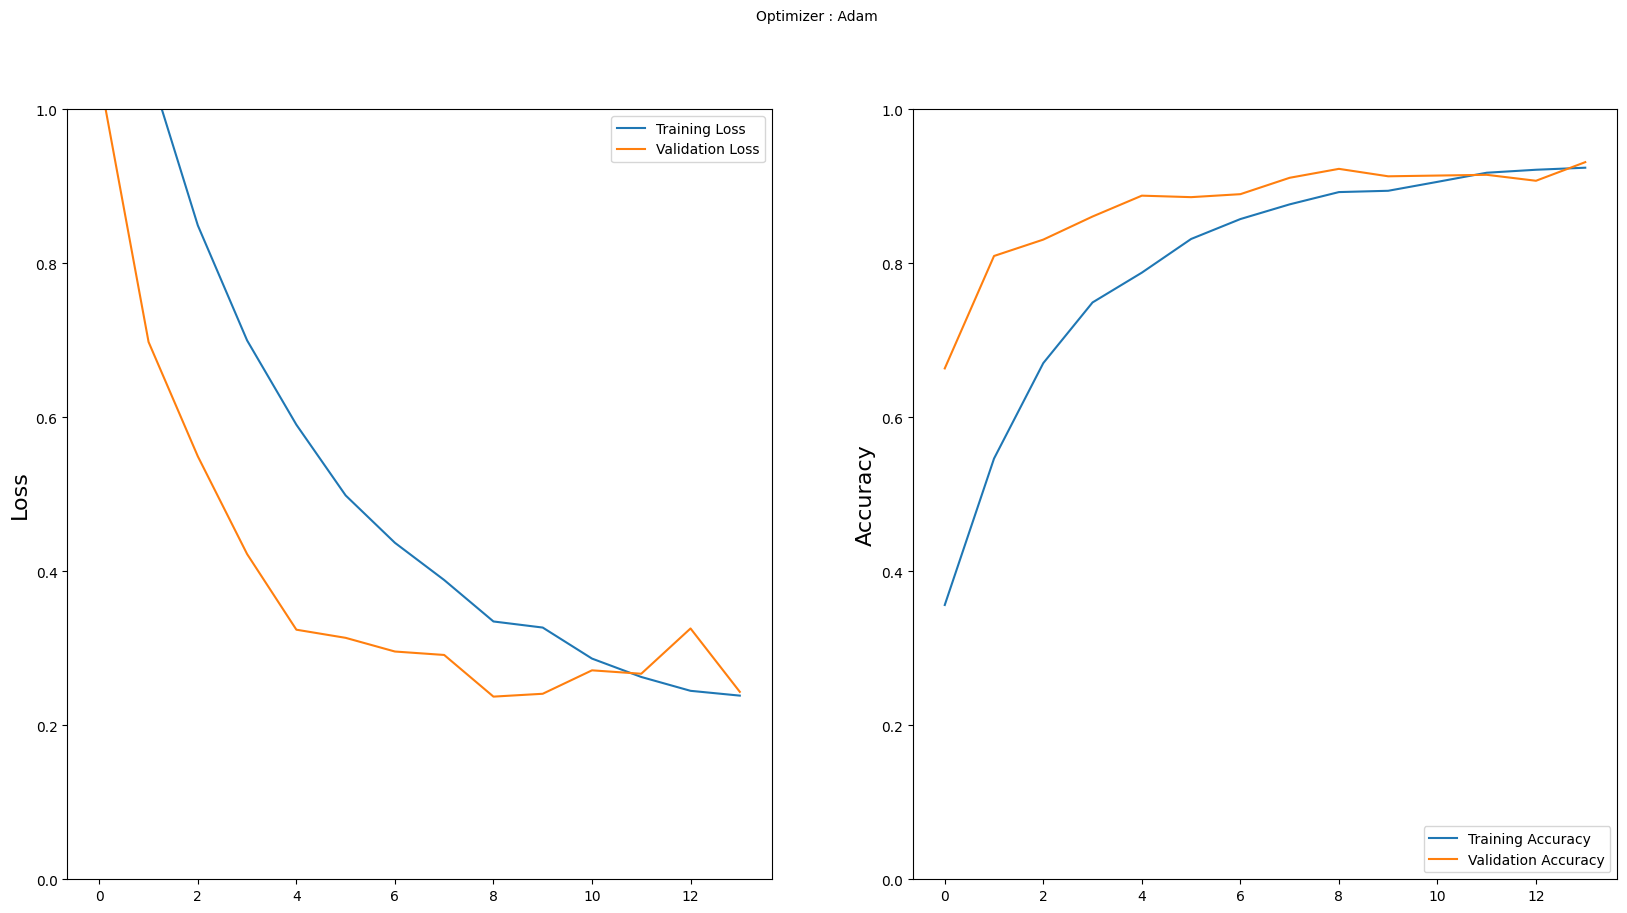

Fold 5/5


<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)
<ipython-input-7-3007643176b6>:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(label_col).apply(lambda x: x.sample(min_size, random_state=42)).reset_index(drop=True)


Found 4040 validated image filenames belonging to 4 classes.
Found 956 validated image filenames belonging to 4 classes.
Found 4138 validated image filenames belonging to 4 classes.
Found 1034 validated image filenames belonging to 4 classes.
Number of layers in the base model:  19


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 43s 577ms/step - accuracy: 0.2886 - loss: 1.4427 - val_accuracy: 0.7253 - val_loss: 1.0130
Epoch 2/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 614ms/step - accuracy: 0.5289 - loss: 1.0691 - val_accuracy: 0.7766 - val_loss: 0.6900
Epoch 3/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 36s 554ms/step - accuracy: 0.6534 - loss: 0.8688 - val_accuracy: 0.8221 - val_loss: 0.5240
Epoch 4/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 608ms/step - accuracy: 0.7431 - loss: 0.6738 - val_accuracy: 0.8675 - val_loss: 0.4284
Epoch 5/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 40s 616ms/step - accuracy: 0.7940 - loss: 0.5747 - val_accuracy: 0.8617 - val_loss: 0.3833
Epoch 6/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 625ms/step - accuracy: 0.8221 - loss: 0.5090 - val_accuracy: 0.8849 - val_loss: 0.3911
Epoch 7/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 35s 532ms/step - accuracy: 0.8430 - loss: 0.4424 - val_accuracy: 0.8956 - val_loss: 0.3265
Epoch 8/30
65/65 ━━━━━━━━━━━━━━━━━━━━ 41s 539ms/step - accuracy: 0.8625 - loss: 0.3967 - val_accu

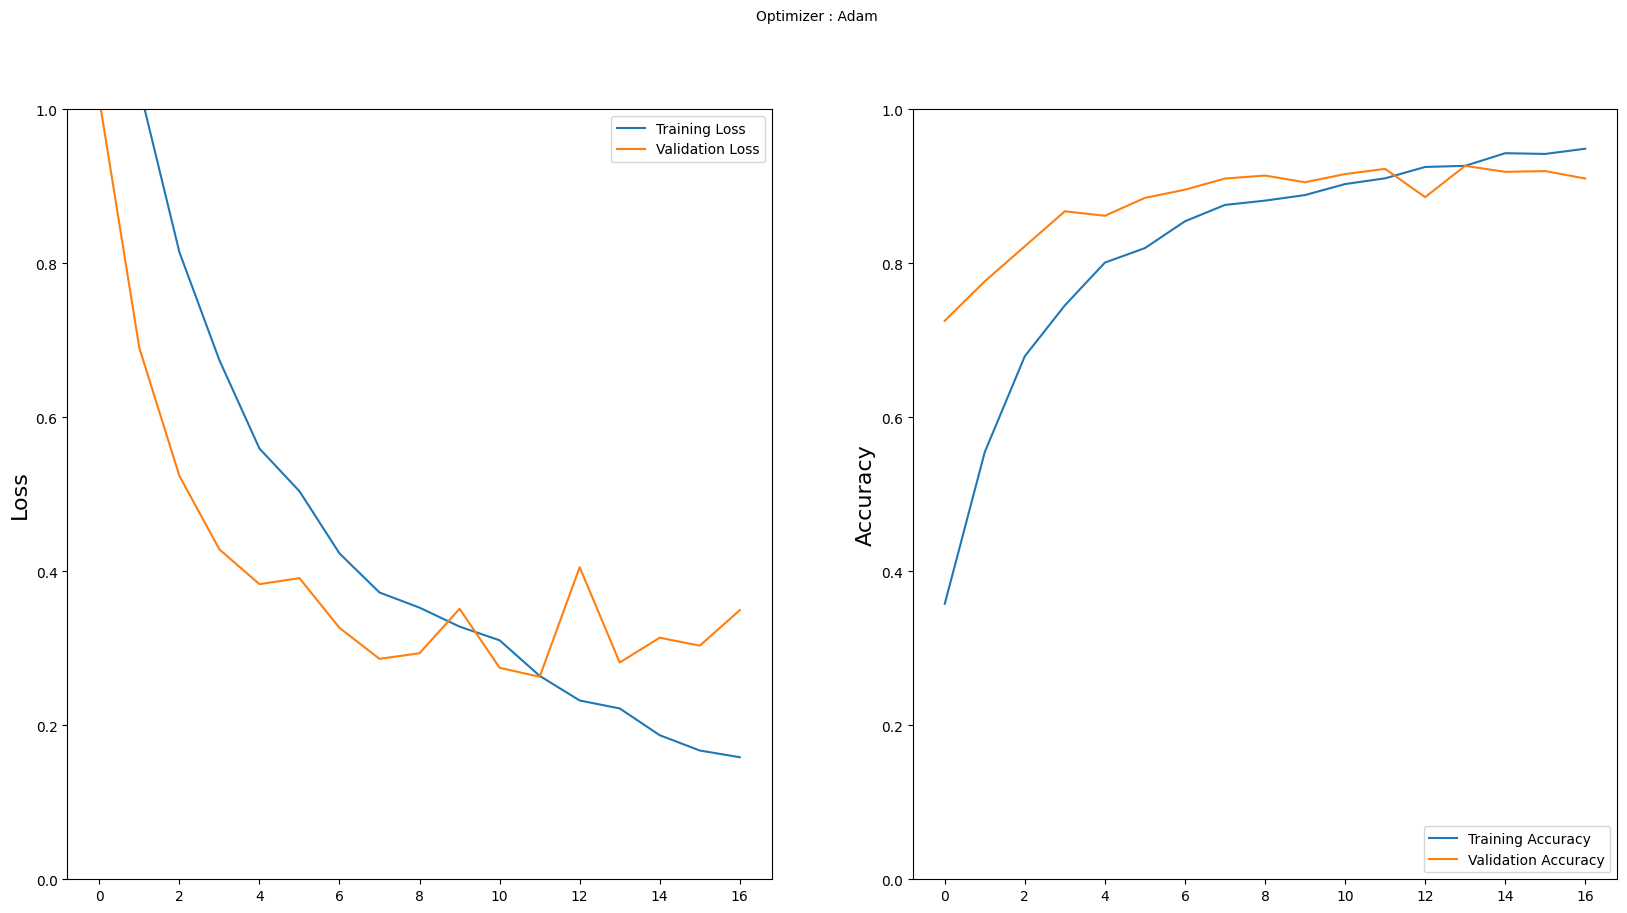

Moyenne des accuracies sur 5 folds: 0.9294


In [ ]:
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import EarlyStopping

input_shape = (224, 224, 3)
batch_size = 64
epochs = 30
k_folds = 5
num_classes = 4

kf = KFold(n_splits=k_folds, shuffle=True, random_state=6)
fold_accuracies = []


image_dir = "/content/drive/My Drive/COVID-19_Radiography_Dataset/train"

for fold, (train_idx, val_idx) in enumerate(kf.split(df_balanced)):
    print(f'Fold {fold+1}/{k_folds}')


    train_df = df_balanced.iloc[train_idx]
    val_df = df_balanced.iloc[val_idx]

    train_df_balanced = balance_dataframe(train_df)
    val_df_balanced = balance_dataframe(val_df)


    train_generator = datagen.flow_from_dataframe(
        train_df_balanced,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df_balanced,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )
    train_generator = datagen.flow_from_dataframe(
        train_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )

    val_generator = datagen.flow_from_dataframe(
        val_df,
        directory=image_dir,
        x_col="filename",
        y_col="class",
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode="categorical"
    )


    model=create_model()
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[early_stopping]
    )


    fold_accuracy = max(history.history['val_accuracy'])
    fold_accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")

    import matplotlib.pyplot as plt


    plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.suptitle('Optimizer : Adam', fontsize=10)
    plt.ylabel('Loss', fontsize=16)
    plt.ylim([0, 1])



    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')

    plt.subplot(1, 2, 2)
    plt.ylabel('Accuracy', fontsize=16)
    plt.ylim([0, 1])


    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.show()

import numpy

print(f'Moyenne des accuracies sur {k_folds} folds: {numpy.mean(fold_accuracies):.4f}')


# Train the model

Everything is set up, let's train our model now!

Our best model managed to obtain a validation accuracy of approximately 65%, which is quite good given the fact that our target class has 7 possible values!

At each epoch, Keras checks if our model performed better than during the previous epochs. If it is the case, the new best model weights are saved into a file. This will allow us to load directly the weights of our model without having to re-train it if we want to use it.

We also have to save the structure of our CNN (layers etc.) into a file:

In [ ]:
model.save('/content/drive/My Drive/covidV16_224.hdf5')
print("SAVED")

SAVED


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

model = load_model("/content/drive/My Drive/covidV16_224.hdf5")
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
    directory='/content/drive/My Drive/COVID-19_Radiography_Dataset/test',
    target_size=(224, 224),
    batch_size=140,
    class_mode='categorical',
    shuffle=False
)


Found 8402 images belonging to 4 classes.


# Analyze the results

We got outputs at each step of the training phase. All those outputs were saved into the 'history' variable. We can use it to plot the evolution of the loss and accuracy on both the train and validation datasets:

The validation accuracy starts to stabilize at the end of the 50 epochs between 60% and 65% accuracy.

The training loss is slightly higher than the validation loss for the first epochs which can be surprising. Indeed we are more used to see higher validation losses than training losses in machine learning. Here this is simply due to the presence of dropout, which is only applied during the training phase and not during the validation phase.

We can see that the training loss is becoming much smaller than the validation loss after the 20th epochs. This means that our model starts to overfit our training dataset after too much iterations. That is why the validation loss does not decrease a lot after. One solution consists in early-stopping the training of the model.

We could also use some different dropout values and performing data augmentation. Those methods were tested on this dataset, but they did not significantly increase the validation accuracy although they reduced the overfitting effect. Using them slightly increased the training duration of the model.

Finally we can plot the confusion matrix in order to see how our model classified the images:

61/61 ━━━━━━━━━━━━━━━━━━━━ 61s 998ms/step
✅ Accuracy: 90.63%


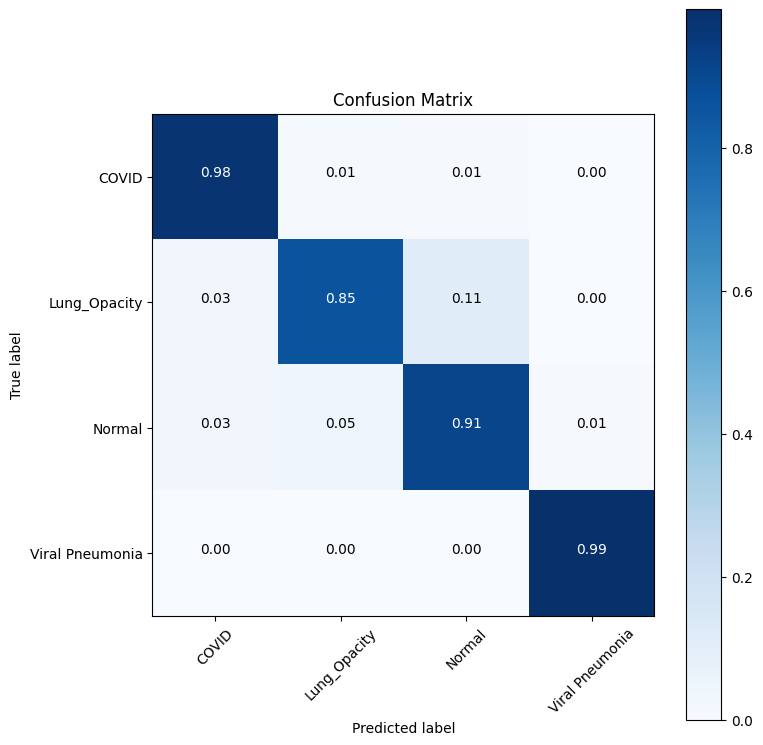

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """Affiche la matrice de confusion normalisée"""
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalisation
    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()


y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())



predictions = model.predict(test_generator, verbose=1)


y_pred = np.argmax(predictions, axis=1)



cnf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)



print(f"✅ Accuracy: {accuracy * 100:.2f}%")
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')